In [1]:
# Input data files are available in the read-only "../input/" directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv


In [17]:
# import libraries
import math
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
from matplotlib import rcParams
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from keras.layers import LSTM
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

plt.style.use("ggplot")
rcParams["figure.figsize"] = [16, 9]
rcParams["xtick.labelsize"] = 14
rcParams["ytick.labelsize"] = 14
rcParams["font.size"] = 14

In [3]:
# load the dataset
data = pd.read_csv('../input/time-series-forecasting-with-yahoo-stock-price/yahoo_stock.csv', parse_dates=True, index_col=0)

In [4]:
data.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [5]:
# check how many null values
data.isnull().sum()

High         0
Low          0
Open         0
Close        0
Volume       0
Adj Close    0
dtype: int64

Text(0.5, 1.0, 'Original:Close')

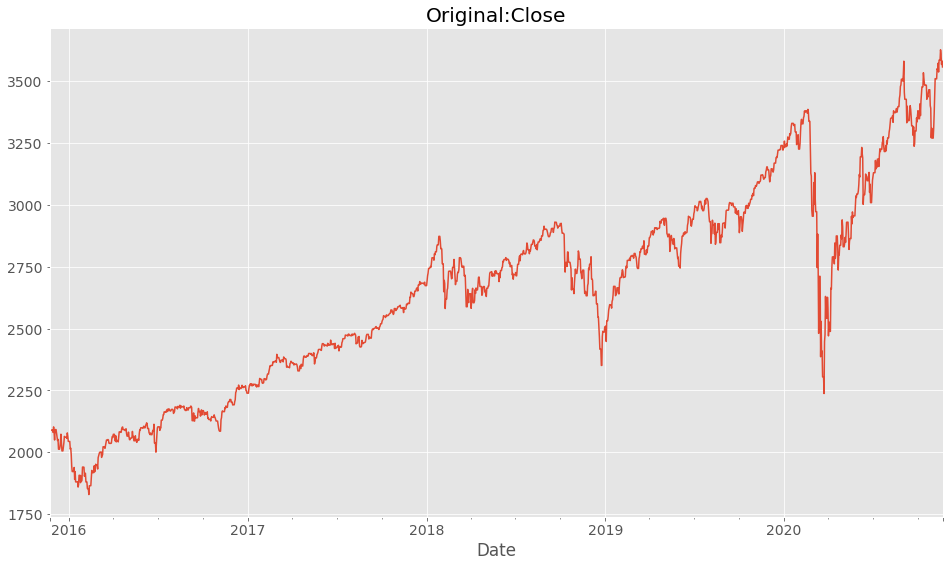

In [6]:
data.Close.plot()
plt.title('Original:Close')

In [7]:
#check time range
print(data.index.min())
print(data.index.max())

2015-11-23 00:00:00
2020-11-20 00:00:00


Text(0.5, 1.0, 'Smoothed')

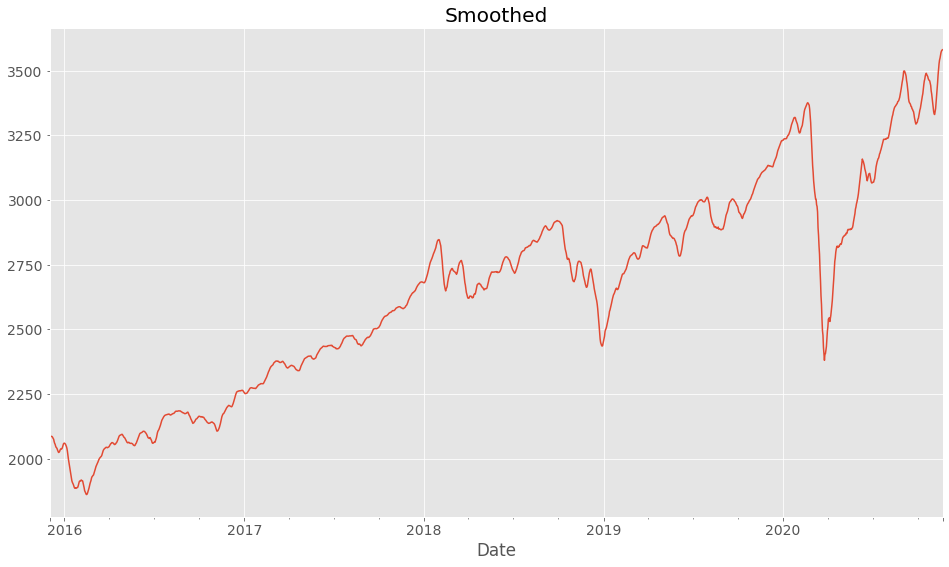

In [8]:
# series to forecast
close_ts = data.Close

# smouth the time seies
ts_smouth = close_ts.rolling(10).mean().dropna()
ts_smouth.plot()
plt.title('Smoothed')

Text(0.5, 1.0, 'Window-Normalized')

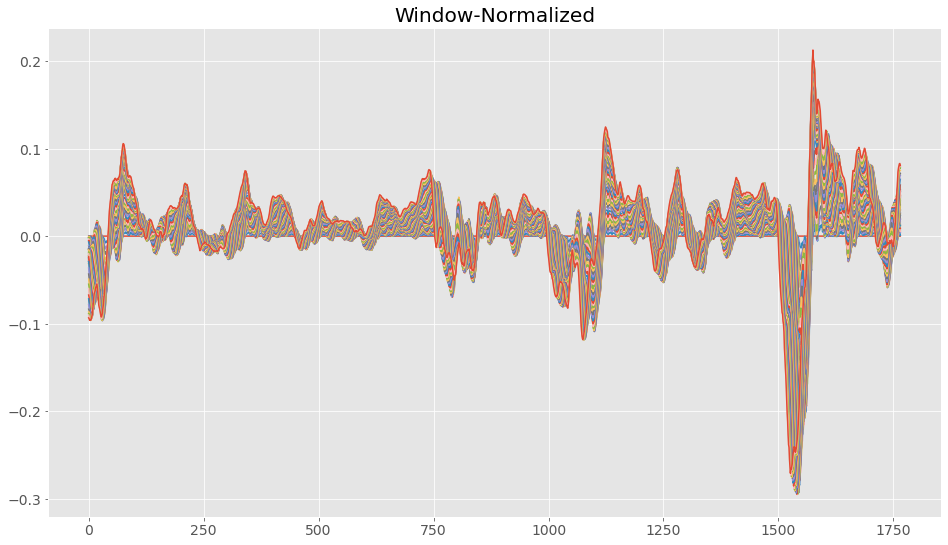

In [9]:
# data normalization in the window
window = 50
ts_lenght = len(ts_smouth)

ts_wind = []
for i in range(ts_lenght - window):
    ts_wind.append(ts_smouth[i: i + window])
    
ts_normalised = []
for window in ts_wind:
    normalised_window = [x / window[0] - 1 for x in window]
    ts_normalised.append(normalised_window)

plt.plot(ts_normalised);
plt.title('Window-Normalized')

In [10]:
# train-test split function
def train_test_split(input_array:list, train_size:float):
    """
    Train-Test splitting fucntion.
    input
    input_array: array, train_size: float {train size from 0 to 1}
    output
    train: array, test: array
    """
    ts_normalised = np.array(input_array)
    n = ts_normalised.shape[0]
    n_rows = int(round(1 - n * train_size))
    
    return ts_normalised[:n_rows, :], ts_normalised[n_rows:, :]


train, test = train_test_split(ts_normalised, 0.2)
print('Train size', train.shape)
print('*' * 20)
print('Test size', test.shape)

Train size (1414, 50)
********************
Test size (352, 50)


In [11]:
# scale data from 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_s = scaler.fit_transform(train)
test_s = scaler.fit_transform(test)

# split independent and dependent variables  
x_train = train_s[:, :-1]
y_train = train_s[:, -1]
        
x_test = test_s[:, :-1]
y_test = test_s[:, -1]

In [34]:
# transfrom data for LSTM input
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

print("x_train {}".format(x_train.shape))
print("y_train {}".format(y_train.shape))
print('*' * 20)
print("x_test {}".format(x_test.shape))
print("y_test {}".format(y_test.shape))

x_train (1414, 49, 1)
y_train (1414,)
********************
x_test (352, 49, 1)
y_test (352,)


In [35]:
# LSTM build
layer_units=[50,100]
window_size=100

model = Sequential()
model.add(LSTM(layer_units[0],input_shape=(window_size,1), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(layer_units[1]))
model.add(Dropout(0.2))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mse", optimizer="rmsprop")
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100, 50)           0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 70,901
Trainable params: 70,901
Non-trainable params: 0
__________________________________________________

In [36]:
# model fit
callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0)]
history = model.fit(x_train, y_train, epochs=20, batch_size=16,
                    verbose=1,validation_split=0.05, callbacks=callbacks)

Epoch 1/20
84/84 [==============================] - 9s 71ms/step - loss: 0.0387 - val_loss: 0.0035
Epoch 2/20
84/84 [==============================] - 4s 52ms/step - loss: 0.0075 - val_loss: 0.0077
Epoch 3/20
84/84 [==============================] - 5s 54ms/step - loss: 0.0052 - val_loss: 0.0056
Epoch 4/20
84/84 [==============================] - 4s 50ms/step - loss: 0.0045 - val_loss: 3.6235e-04
Epoch 5/20
84/84 [==============================] - 4s 49ms/step - loss: 0.0035 - val_loss: 3.1809e-04
Epoch 6/20
84/84 [==============================] - 4s 51ms/step - loss: 0.0034 - val_loss: 0.0016
Epoch 7/20
84/84 [==============================] - 4s 50ms/step - loss: 0.0028 - val_loss: 1.6087e-04
Epoch 8/20
84/84 [==============================] - 4s 50ms/step - loss: 0.0027 - val_loss: 4.7605e-04
Epoch 9/20
84/84 [==============================] - 4s 50ms/step - loss: 0.0028 - val_loss: 0.0018
Epoch 10/20
84/84 [==============================] - 4s 49ms/step - loss: 0.0025 - val_loss: 

dict_keys(['loss', 'val_loss'])


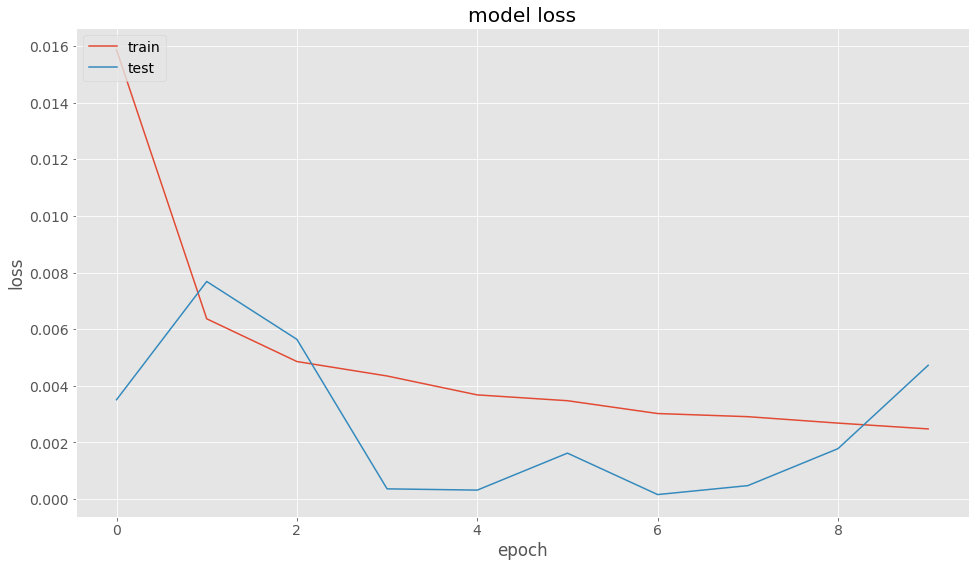

In [37]:
# summarize history for loss
print(history.history.keys())

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
# forecasting and RMSE
test_len = len(x_test)
predict_len = 3
window_size = 6
prediction_list = []

for window in range(int(test_len/predict_len)):
    sequence = x_test[window*predict_len]
    
    forecast = []
    for _ in range(predict_len):
        forecast.append(model.predict(sequence[np.newaxis,:,:])[0,0])
        sequence = sequence[1:]
        sequence = np.insert(sequence, [window_size-1], forecast[-1], axis=0)
    
    prediction_list.append(forecast)
    

test_offset = y_test.shape[0] - np.array(prediction_list).flatten().shape[0]
test_rmse = math.sqrt(mean_squared_error(y_test[test_offset:], np.array(prediction_list).flatten()))

print('Test Score: %.2f RMSE' % (test_rmse))

Test Score: 0.08 RMSE


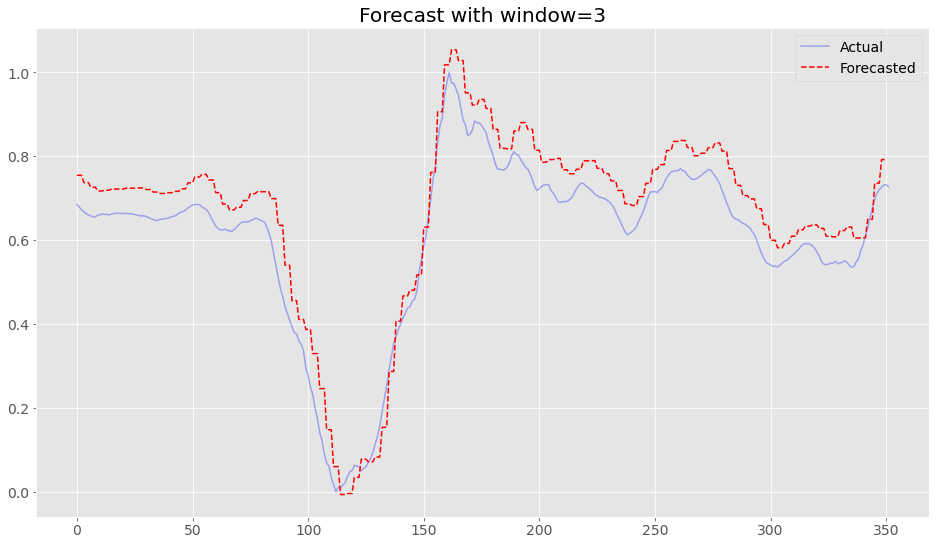

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)

 # plot actual
ax.plot(y_test, label='Actual', c='blue',alpha=0.3)
    
# plot forecasted
plt.plot(np.array(prediction_list).flatten(), label='Forecasted', c='red',linestyle='--')
plt.title("Forecast with window={}".format(predict_len))
ax.legend()